In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xopr.opr_access
import pandas as pd # For time types
import scipy.constants

from radar_line_processing import *

In [3]:
parameters = {
    'layer_selection_margin_m': 100,  # meters
    'ice_relative_permittivity': 3.17,  # Relative permittivity of ice
}

urls = [f'https://data.cresis.ku.edu/data/rds/2016_Antarctica_DC8/CSARP_standard/20161026_05/Data_20161026_05_{i:03d}.mat' for i in range(3, 6)] #range(1, 43)

In [4]:
# Establish an OPR session
# The purpose of this right now is just to define a local cache directory, but 
# in the future we might use it to determine which STAC catalog to use or something.
opr = xopr.opr_access.OPRConnection(cache_dir="radar_cache")

In [5]:
# results = process_radar_line(
#     opr_connection=opr,
#     urls=urls,
#     output_storage_location='tmp',
# )

In [6]:
# path = 'tmp/reflectivity_2016_Antarctica_DC8_20161026_05.zarr.zip'
# store = zarr.storage.ZipStore(path, mode='r')
# test = xr.open_dataset(store, engine='zarr')
# test

In [7]:
# Load one line of radar data
# TODO: This is a temporary solution until we get the STAC catalog API working.
urls = [f'https://data.cresis.ku.edu/data/rds/2016_Antarctica_DC8/CSARP_standard/20161026_05/Data_20161026_05_{i:03d}.mat' for i in range(1, 43)]

frames = [opr.load_frame(url) for url in urls]

# Combine the frames into a single xarray Dataset representing the flight line
flight_line = xr.concat(frames, dim='slow_time', combine_attrs='drop_conflicts')

flight_line = flight_line.resample(slow_time='1s').mean()

layers = xopr.opr_access.get_layers(flight_line)
flight_line

<xarray.Dataset> Size: 151MB
Dimensions:    (slow_time: 9348, twtt: 4024)
Coordinates:
  * twtt       (twtt) float64 32kB 3.737e-05 3.739e-05 ... 0.0001186 0.0001186
  * slow_time  (slow_time) datetime64[ns] 75kB 2016-10-26T20:00:33 ... 2016-1...
Data variables:
    Bottom     (slow_time) float64 75kB nan nan nan nan nan ... nan nan nan nan
    Data       (slow_time, twtt) float32 150MB 7.005e-19 1.176e-18 ... 7.686e-21
    Elevation  (slow_time) float64 75kB 9.274e+03 9.275e+03 ... 9.688e+03
    Heading    (slow_time) float64 75kB -0.003578 -0.005032 ... -0.1532 -0.1533
    Latitude   (slow_time) float64 75kB -89.21 -89.21 -89.21 ... -70.36 -70.36
    Longitude  (slow_time) float64 75kB -67.92 -67.92 -67.92 ... -70.0 -70.0
    Pitch      (slow_time) float64 75kB 0.01982 0.02041 ... 0.01764 0.01768
    Roll       (slow_time) float64 75kB -0.07392 -0.07439 ... -0.005006
    Surface    (slow_time) float64 75kB 4.361e-05 4.361e-05 ... 6.324e-05
Attributes:
    Conventions:  CF-1.8
    title:        Radar Echogram Data
    institution:  Open Polar Radar (OPR)
    source:       Airborne/ground-based radar sounder
    references:   https://gitlab.com/openpolarradar/opr
    comment:      Polar radar echogram data with CF-compliant metadata
    season:       2016_Antarctica_DC8
    segment:      20161026_05

In [8]:
speed_of_light_in_ice = scipy.constants.c / np.sqrt(parameters['ice_relative_permittivity'])  # Speed of light in ice (m/s)

layer_selection_margin_twtt = parameters['layer_selection_margin_m'] / speed_of_light_in_ice # approx 50 m margin in ice

surface_repicked_twtt, surface_power = extract_layer_peak_power(flight_line, layers[1]['twtt'], layer_selection_margin_twtt)
bed_repicked_twtt, bed_power = extract_layer_peak_power(flight_line, layers[2]['twtt'], layer_selection_margin_twtt)

In [9]:
# Create a dataset from surface_repicked_twtt, bed_repicked_twtt, surface_power, and bed_power

reflectivity_dataset = xr.merge([
    surface_repicked_twtt.rename('surface_twtt'),
    bed_repicked_twtt.rename('bed_twtt'),
    surface_power.rename('surface_power_dB'),
    bed_power.rename('bed_power_dB'),
    ])

flight_line_metadata = flight_line.drop_vars(['Data', 'Surface', 'Bottom'])
reflectivity_dataset = xr.merge([reflectivity_dataset, flight_line_metadata])

attributes_to_copy = ['season', 'segment', 'doi', 'ror', 'funder_text']
reflectivity_dataset.attrs = {attr: flight_line.attrs[attr] for attr in attributes_to_copy if attr in flight_line.attrs}

reflectivity_dataset.attrs['source_urls'] = urls

reflectivity_dataset

<xarray.Dataset> Size: 780kB
Dimensions:           (slow_time: 9348, twtt: 4024)
Coordinates:
  * slow_time         (slow_time) datetime64[ns] 75kB 2016-10-26T20:00:33 ......
  * twtt              (twtt) float64 32kB 3.737e-05 3.739e-05 ... 0.0001186
Data variables:
    surface_twtt      (slow_time) float64 75kB 4.364e-05 4.364e-05 ... 6.404e-05
    bed_twtt          (slow_time) float64 75kB nan nan nan nan ... nan nan nan
    surface_power_dB  (slow_time) float32 37kB -56.28 -56.09 ... -61.39 -66.79
    bed_power_dB      (slow_time) float32 37kB nan nan nan nan ... nan nan nan
    Elevation         (slow_time) float64 75kB 9.274e+03 9.275e+03 ... 9.688e+03
    Heading           (slow_time) float64 75kB -0.003578 -0.005032 ... -0.1533
    Latitude          (slow_time) float64 75kB -89.21 -89.21 ... -70.36 -70.36
    Longitude         (slow_time) float64 75kB -67.92 -67.92 ... -70.0 -70.0
    Pitch             (slow_time) float64 75kB 0.01982 0.02041 ... 0.01768
    Roll              (slow_time) float64 75kB -0.07392 -0.07439 ... -0.005006
Attributes:
    season:       2016_Antarctica_DC8
    segment:      20161026_05
    source_urls:  ['https://data.cresis.ku.edu/data/rds/2016_Antarctica_DC8/C...

In [10]:
# Get total time range in hours
time_delta = pd.to_timedelta((flight_line.slow_time.max() - flight_line.slow_time.min()).item())
total_time_range_hours = time_delta.total_seconds() / 3600
print(f"Total time range: {total_time_range_hours:.2f} hours")

Total time range: 2.60 hours


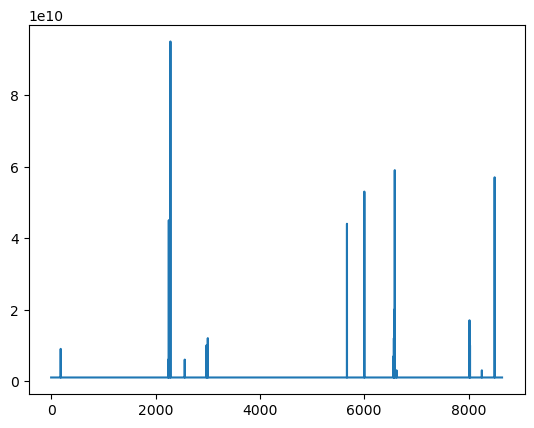

In [11]:
plt.plot(np.diff(bed_power.slow_time))

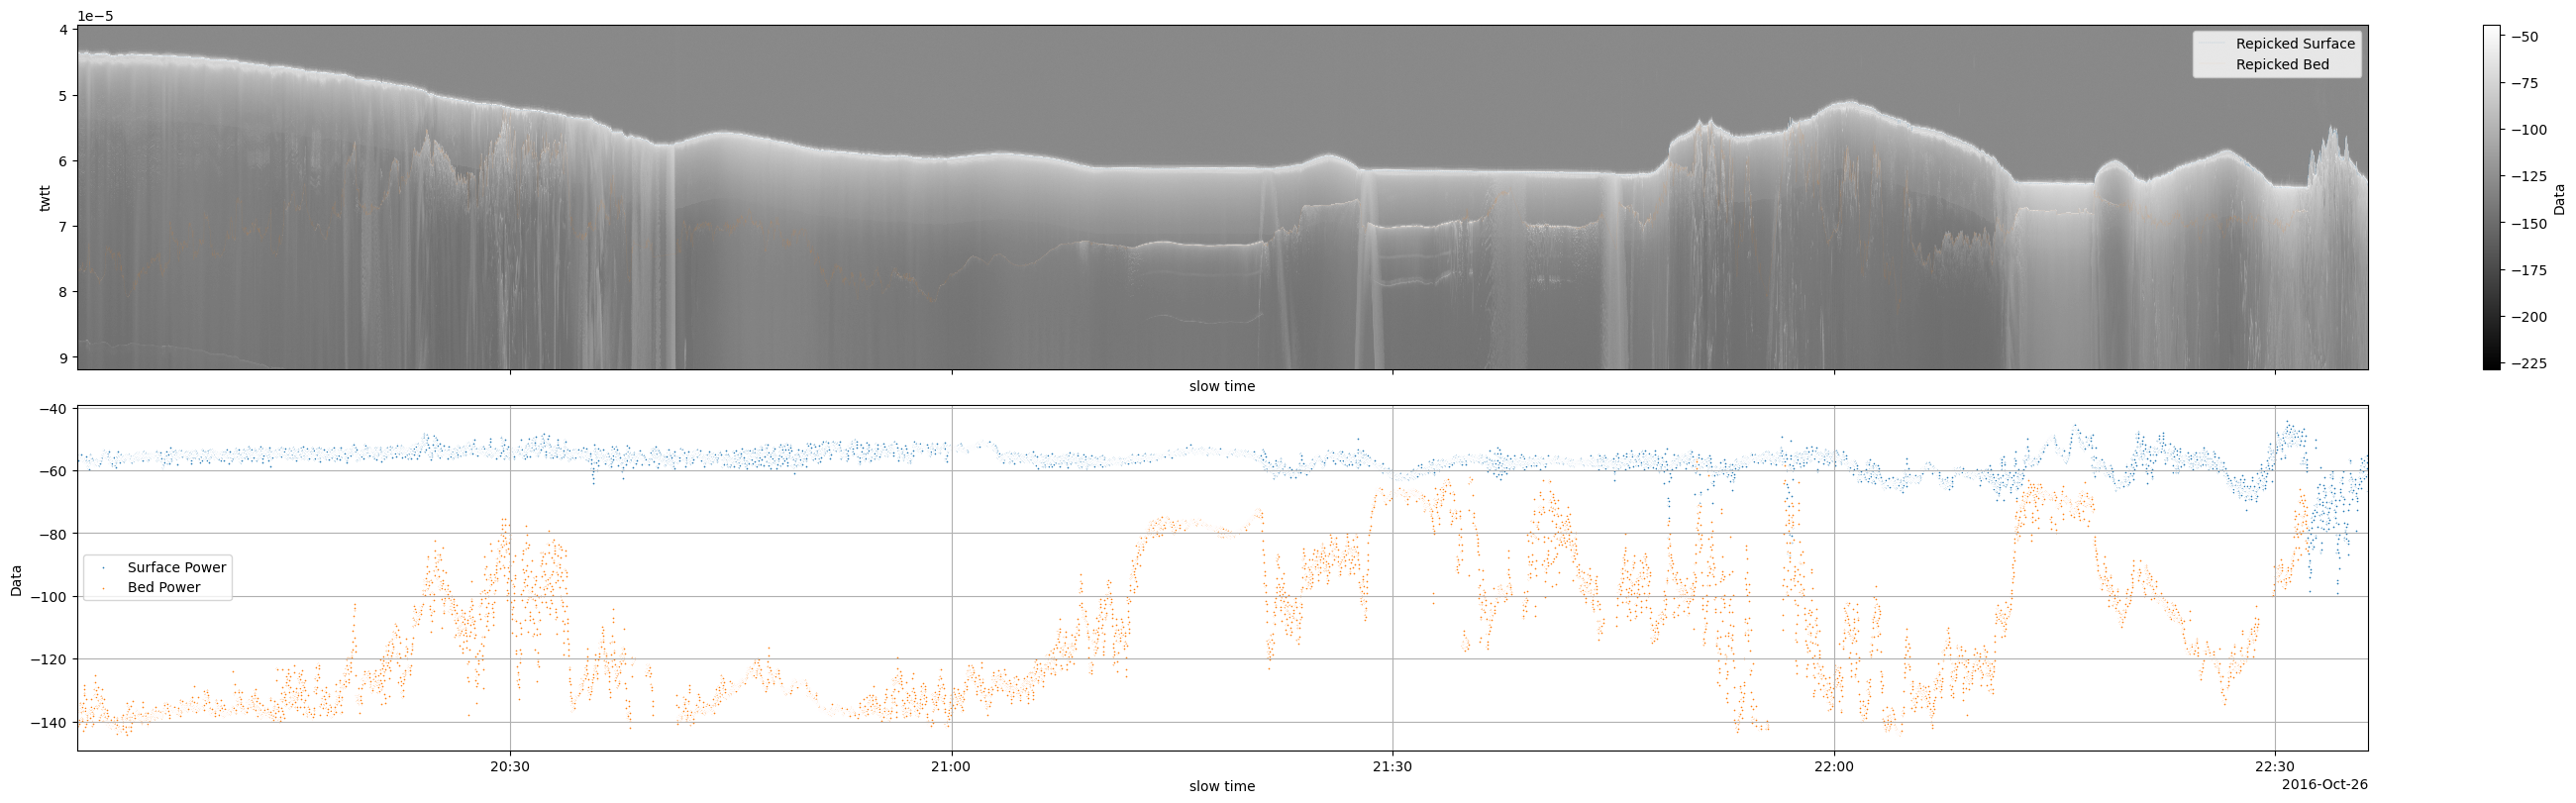

In [12]:
fig, (ax_radar, ax_pwr) = plt.subplots(2,1, figsize=(total_time_range_hours*10, 8), sharex=True, constrained_layout=True)

pwr_dB = 10*np.log10(np.abs(flight_line.Data))
pwr_dB.plot.imshow(x='slow_time', cmap='gray', ax=ax_radar)
ax_radar.invert_yaxis()

#layers[1].twtt.plot(ax=ax_radar, x='slow_time', c='C0', linestyle=':', alpha=0.5, linewidth=0.5, label='Surface')
surface_repicked_twtt.plot(ax=ax_radar, x='slow_time', c='C0', linestyle='--', alpha=0.3, linewidth=0.3, label='Repicked Surface')
#layers[2].twtt.plot(ax=ax_radar, x='slow_time', c='C1', linestyle='--', alpha=0.5, linewidth=0.5, label='Bed')
bed_repicked_twtt.plot(ax=ax_radar, x='slow_time', c='C1', linestyle=':', alpha=0.3, linewidth=0.3, label='Repicked Bed')

# Find good y limits
y_min = min(surface_repicked_twtt.min(), bed_repicked_twtt.min()) * 0.9
y_max = max(surface_repicked_twtt.max(), bed_repicked_twtt.max()) * 1.1

ax_radar.set_ylim(y_max, y_min)
ax_radar.legend()

surface_power.plot.scatter(ax=ax_pwr, x='slow_time', label='Surface Power', s=5)
bed_power.plot.scatter(ax=ax_pwr, x='slow_time', label='Bed Power', s=5)

ax_pwr.legend()
ax_pwr.grid()